# Additional Analysis: No-Mortality Predictors

This notebook addresses the reviewer request by removing mortality-related predictors and re-running the analysis with non-mortality variables only.

## What is excluded as bias-prone/tautological here
- `adult_mortality_15_60`
- `u5_mortality_rate`
- `infant_deaths`
- `log_infant_deaths`

The goal is to evaluate which **other** indicators still explain life expectancy and how strong their contributions are.


## 1) Imports and Paths

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

# Resolve project root whether run from repo root or Codes/
CWD = Path.cwd().resolve()
if (CWD / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

DATA_DIR = PROJECT_ROOT / 'Assets' / 'cleaner_exports'
FULL_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'

if not FULL_PATH.exists():
    raise FileNotFoundError(f'Missing required file: {FULL_PATH.resolve()}')

TARGET = 'life_expectancy'
print('Project root:', PROJECT_ROOT)
print('Data dir    :', DATA_DIR)

Project root: /Users/bikki/Documents/Projects_Spring_2026/STATS201
Data dir    : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports


## 2) Load Data

In [2]:
full_df = pd.read_csv(FULL_PATH)

# 70-30 temporal split by years (first 70% years for train, last 30% years for test)
years = sorted(full_df['Year'].dropna().astype(int).unique().tolist())
n_years = len(years)
train_n = max(1, int(np.floor(0.70 * n_years)))
train_years = years[:train_n]
test_years = years[train_n:]

if len(test_years) == 0:
    raise ValueError('Test years are empty. Check Year coverage before splitting.')

train_df = full_df[full_df['Year'].isin(train_years)].copy()
test_df = full_df[full_df['Year'].isin(test_years)].copy()

train_ratio = len(train_df) / len(full_df)
test_ratio = len(test_df) / len(full_df)

print('Full shape :', full_df.shape)
print('Train shape:', train_df.shape, '| years:', min(train_years), '-', max(train_years))
print('Test shape :', test_df.shape, '| years:', min(test_years), '-', max(test_years))
print(f'Row split ratio -> train: {train_ratio:.3f}, test: {test_ratio:.3f}')

Full shape : (4224, 19)
Train shape: (3456, 19) | years: 2000 - 2017
Test shape : (768, 19) | years: 2018 - 2021


## 3) Define No-Mortality Feature Sets

In [3]:
bias_mortality_vars = [
    'adult_mortality_15_60',
    'u5_mortality_rate',
    'infant_deaths',
    'log_infant_deaths',
]

# Core non-mortality variables
no_mortality_base = [
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
]

# Engineered (domain transform) variant without mortality variables
no_mortality_engineered = [
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
]

print('Excluded variables:', bias_mortality_vars)
print('No-mortality base features      :', len(no_mortality_base))
print('No-mortality engineered features:', len(no_mortality_engineered))


Excluded variables: ['adult_mortality_15_60', 'u5_mortality_rate', 'infant_deaths', 'log_infant_deaths']
No-mortality base features      : 9
No-mortality engineered features: 9


## 4) Build Matrices and Evaluate Models

In [4]:
def make_xy(train_panel, test_panel, feature_set: str):
    if feature_set == 'base_no_mortality':
        cols = no_mortality_base
        X_train_raw = train_panel[cols].copy()
        X_test_raw = test_panel[cols].copy()

    elif feature_set == 'engineered_no_mortality':
        cols = no_mortality_engineered
        X_train_raw = train_panel[cols].copy()
        X_test_raw = test_panel[cols].copy()

    elif feature_set == 'polynomial_no_mortality':
        cols = no_mortality_base
        poly = PolynomialFeatures(degree=2, include_bias=False)

        X_train_base = train_panel[cols].copy()
        X_test_base = test_panel[cols].copy()

        X_train_raw = pd.DataFrame(
            poly.fit_transform(X_train_base),
            columns=poly.get_feature_names_out(cols),
            index=X_train_base.index,
        )
        X_test_raw = pd.DataFrame(
            poly.transform(X_test_base),
            columns=poly.get_feature_names_out(cols),
            index=X_test_base.index,
        )
        cols = X_train_raw.columns.tolist()

    else:
        raise ValueError(f'Unknown feature_set: {feature_set}')

    y_train = train_panel[TARGET].to_numpy()
    y_test = test_panel[TARGET].to_numpy()
    return X_train_raw, X_test_raw, y_train, y_test, cols


def eval_metrics(y_train, yhat_train, y_test, yhat_test):
    return {
        'Train_R2': r2_score(y_train, yhat_train),
        'Test_R2': r2_score(y_test, yhat_test),
        'Train_RMSE': float(np.sqrt(mean_squared_error(y_train, yhat_train))),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, yhat_test))),
        'Train_MAE': mean_absolute_error(y_train, yhat_train),
        'Test_MAE': mean_absolute_error(y_test, yhat_test),
    }


models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Random Forest (300,15)': RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    'Gradient Boosting (200,3)': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=3,
        random_state=RANDOM_STATE,
    ),
}

results = []
artifacts = {}

for fs in ['base_no_mortality', 'engineered_no_mortality', 'polynomial_no_mortality']:
    X_train_raw, X_test_raw, y_train, y_test, feat_names = make_xy(train_df, test_df, fs)

    for mname, model in models.items():
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model),
        ])
        pipe.fit(X_train_raw, y_train)

        yhat_train = pipe.predict(X_train_raw)
        yhat_test = pipe.predict(X_test_raw)
        met = eval_metrics(y_train, yhat_train, y_test, yhat_test)

        row = {
            'Model': mname,
            'Feature_Set': fs,
            'N_Features': len(feat_names),
            **met,
        }
        results.append(row)

        artifacts[(mname, fs)] = {
            'pipeline': pipe,
            'X_train_raw': X_train_raw,
            'X_test_raw': X_test_raw,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': feat_names,
        }

results_df = pd.DataFrame(results).sort_values(['Test_R2', 'Test_RMSE'], ascending=[False, True]).reset_index(drop=True)
results_df


,Model,Feature_Set,N_Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
0,"Random Forest (300,15)",polynomial_no_mortality,54,0.996270,0.876587,0.524914,2.468240,0.329211,1.700216
1,"Random Forest (300,15)",base_no_mortality,9,0.995856,0.848166,0.553330,2.737738,0.345766,1.850492
2,"Random Forest (300,15)",engineered_no_mortality,9,0.995853,0.847815,0.553487,2.740899,0.345448,1.852484
3,"Gradient Boosting (200,3)",polynomial_no_mortality,54,0.959663,0.815112,1.726295,3.021078,1.230113,2.243350
4,"Gradient Boosting (200,3)",base_no_mortality,9,0.934951,0.785271,2.192216,3.255763,1.511009,2.429373
5,"Gradient Boosting (200,3)",engineered_no_mortality,9,0.934951,0.785271,2.192216,3.255763,1.511009,2.429373
6,Ridge (alpha=1.0),polynomial_no_mortality,54,0.775697,0.683207,4.070800,3.954537,2.981391,3.096582
7,Linear Regression,polynomial_no_mortality,54,0.777754,0.679338,4.052082,3.978612,2.982310,3.132916
8,Ridge (alpha=1.0),engineered_no_mortality,9,0.709315,0.664516,4.634182,4.069522,3.393072,3.200293
9,Linear Regression,engineered_no_mortality,9,0.709315,0.664501,4.634181,4.069616,3.392927,3.200227


## 5) Graph 1: Performance Without Mortality Variables

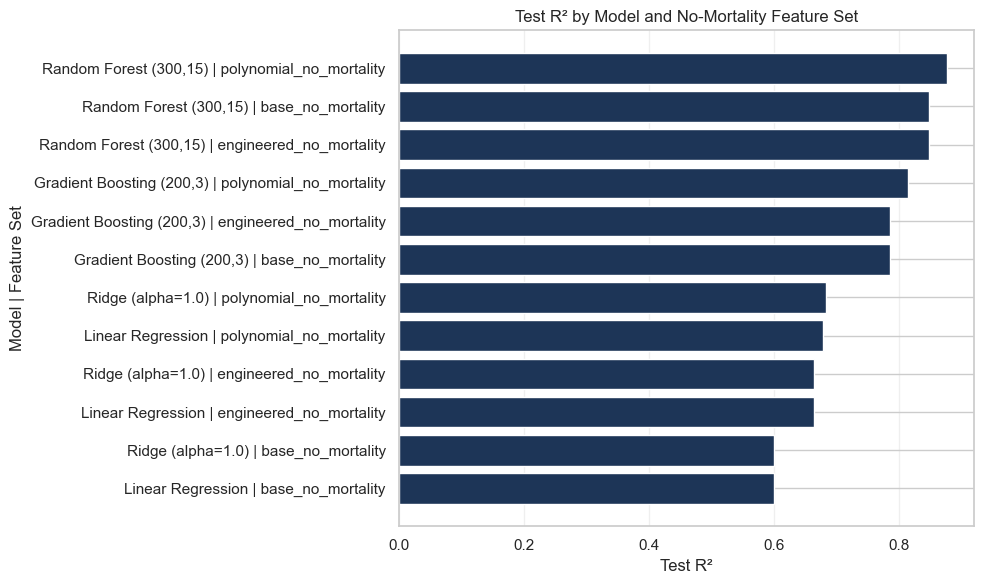

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df = results_df.copy()
plot_df['Model+Set'] = plot_df['Model'] + ' | ' + plot_df['Feature_Set']
plot_df = plot_df.sort_values('Test_R2', ascending=True)

ax.barh(plot_df['Model+Set'], plot_df['Test_R2'], color='#1d3557')
ax.set_title('Test R² by Model and No-Mortality Feature Set')
ax.set_xlabel('Test R²')
ax.set_ylabel('Model | Feature Set')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 6) Select Best No-Mortality Model

In [6]:
best_row = results_df.iloc[0]
best_key = (best_row['Model'], best_row['Feature_Set'])
best = artifacts[best_key]

print('Best no-mortality model combination:')
print(best_row[['Model', 'Feature_Set', 'N_Features', 'Test_R2', 'Test_RMSE', 'Test_MAE']])


Best no-mortality model combination:
Model           Random Forest (300,15)
Feature_Set    polynomial_no_mortality
N_Features                          54
Test_R2                       0.876587
Test_RMSE                      2.46824
Test_MAE                      1.700216
Name: 0, dtype: object


## 7) Variable Weightage (Random Forest + Permutation Importance)

In [7]:
# Use permutation importance on test set to get robust feature weightage
pi = permutation_importance(
    estimator=best['pipeline'],
    X=best['X_test_raw'],
    y=best['y_test'],
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring='r2',
)

imp_df = pd.DataFrame({
    'Feature': best['feature_names'],
    'Importance': pi.importances_mean,
})
imp_df = imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
imp_df['Weight_%'] = 100 * imp_df['Importance'] / imp_df['Importance'].sum()

imp_df.head(15)


,Feature,Importance,Weight_%
0,che_pct_gdp gdp_per_capita_2015usd,0.352054,38.414785
1,pol3_coverage_pct gdp_per_capita_2015usd,0.113043,12.334816
2,che_pct_gdp underweight_adults_pct,0.050467,5.506742
3,alcohol_per_capita_15plus thinness_children_ad...,0.049915,5.446573
4,dtp3_coverage_pct gdp_per_capita_2015usd,0.047260,5.156821
5,alcohol_per_capita_15plus underweight_adults_pct,0.038063,4.153288
6,overweight_adults_pct underweight_adults_pct,0.023331,2.545820
7,dtp3_coverage_pct thinness_children_adolescent...,0.023256,2.537651
8,dtp3_coverage_pct overweight_adults_pct,0.023041,2.514188
9,che_pct_gdp overweight_adults_pct,0.020170,2.200871


## 8) Graph 2: Top Variable Weightage (No-Mortality Model)

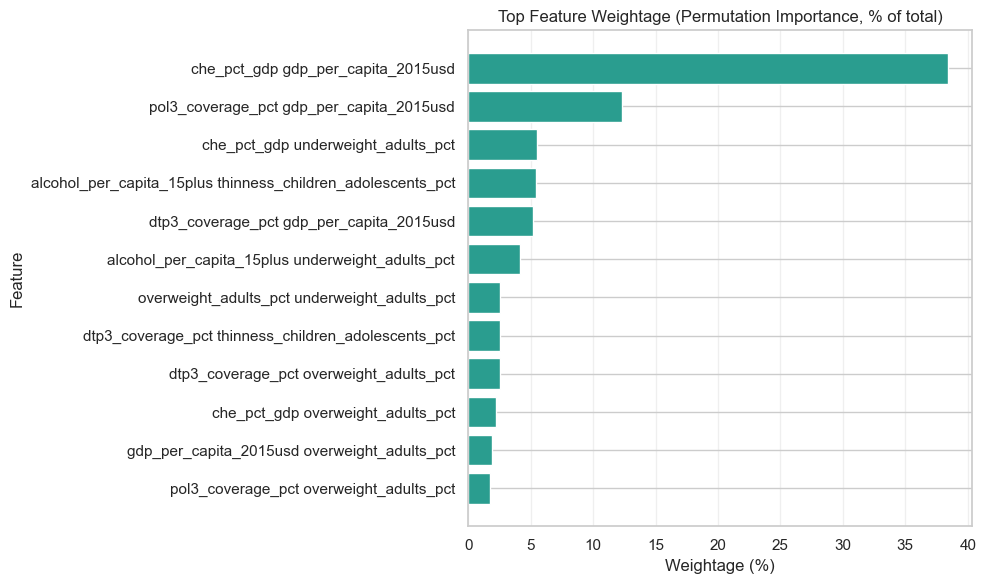

In [8]:
top_n = min(12, len(imp_df))
plot_imp = imp_df.head(top_n).sort_values('Weight_%', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_imp['Feature'], plot_imp['Weight_%'], color='#2a9d8f')
ax.set_title('Top Feature Weightage (Permutation Importance, % of total)')
ax.set_xlabel('Weightage (%)')
ax.set_ylabel('Feature')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 9) Cross-Check Weightage with Standardized Linear Coefficients

In [9]:
lin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0, random_state=RANDOM_STATE)),
])

# Use engineered no-mortality set for interpretability
X_train_raw, X_test_raw, y_train, y_test, feat_names = make_xy(train_df, test_df, 'engineered_no_mortality')
lin_pipe.fit(X_train_raw, y_train)

coef = lin_pipe.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': feat_names,
    'Std_Coefficient': coef,
    'Abs_Std_Coefficient': np.abs(coef),
}).sort_values('Abs_Std_Coefficient', ascending=False)

coef_df['Weight_%'] = 100 * coef_df['Abs_Std_Coefficient'] / coef_df['Abs_Std_Coefficient'].sum()
print('Ridge (engineered_no_mortality) Test R²:', round(r2_score(y_test, lin_pipe.predict(X_test_raw)), 4))
coef_df


Ridge (engineered_no_mortality) Test R²: 0.6645


,Feature,Std_Coefficient,Abs_Std_Coefficient,Weight_%
5,log_gdp_per_capita_2015usd,5.053855,5.053855,47.500336
3,pol3_coverage_pct,1.663621,1.663621,15.636095
7,underweight_adults_pct,-1.058425,1.058425,9.947958
8,thinness_children_adolescents_pct,0.772218,0.772218,7.257951
6,overweight_adults_pct,0.762201,0.762201,7.163802
4,dtp3_coverage_pct,0.586362,0.586362,5.511115
0,alcohol_per_capita_15plus,-0.399745,0.399745,3.757133
1,che_pct_gdp,0.280520,0.280520,2.636564
2,hepb3_coverage_pct,0.062672,0.062672,0.589045


## 10) Graph 3: Linear Model Weightage (No-Mortality Features)

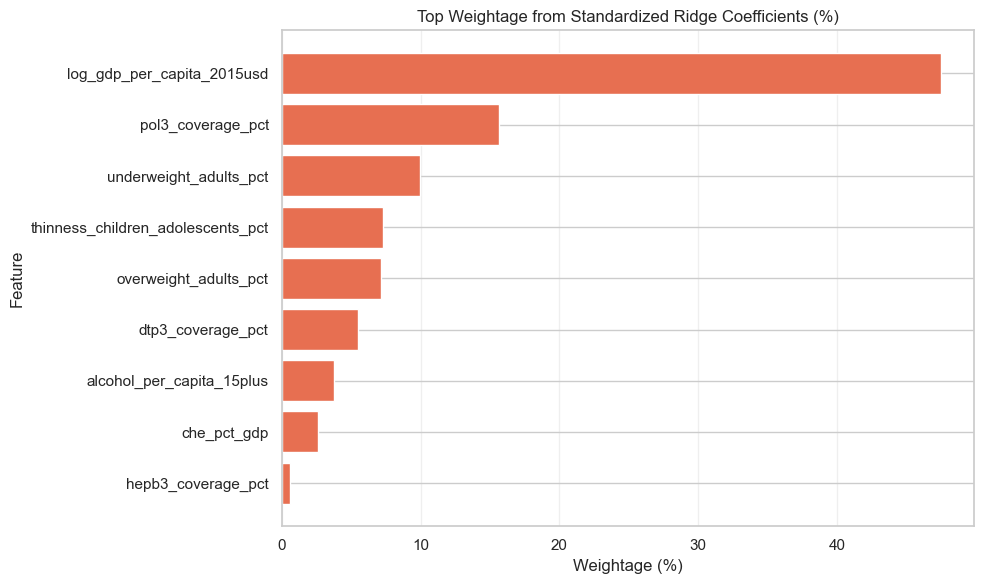

In [10]:
plot_coef = coef_df.head(10).sort_values('Weight_%', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_coef['Feature'], plot_coef['Weight_%'], color='#e76f51')
ax.set_title('Top Weightage from Standardized Ridge Coefficients (%)')
ax.set_xlabel('Weightage (%)')
ax.set_ylabel('Feature')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 11) Concise Interpretation

- All model runs in this notebook exclude mortality/death variables (`adult_mortality_15_60`, `u5_mortality_rate`, `infant_deaths`, `log_infant_deaths`).
- The model-comparison table and Graph 1 show how much predictive performance remains from non-mortality indicators.
- The weightage tables and Graphs 2-3 identify the strongest non-mortality drivers.
- Report both permutation-based and linear-coefficient-based weightage to avoid relying on one interpretation method.


## 12) Final Summary

This no-mortality analysis re-estimates life-expectancy models after excluding direct mortality/death indicators (`adult_mortality_15_60`, `u5_mortality_rate`, `infant_deaths`, `log_infant_deaths`). Across the tested pipelines, predictive performance remains meaningful, showing that non-mortality factors still contain substantial signal.

The strongest remaining predictors are primarily socioeconomic and health-system coverage/financing variables (as shown in the permutation-importance and standardized-coefficient weightage tables). This indicates that differences in economic conditions, immunization coverage, health spending structure, and nutrition-risk profile explain a sizable share of life-expectancy variation even without mortality-based inputs.

Interpretation should remain associative rather than causal: these feature weights describe model dependence in this dataset and temporal split, not guaranteed policy effect sizes. Still, the results provide a clearer, less tautological view of which non-mortality indicators are most informative for prediction.
